# Importações

In [1]:
import cudf as pd
import cupy
import dask
import gc
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas
import random

from sklearn.metrics import mean_absolute_percentage_error

from pyESN import ESN

import tensorflow as tf

from cuml.svm import svr
from cuml import RandomForestRegressor as CudaRandomForest
from keras import Sequential
from keras.src.layers import Input, LSTM, Dense
from pyswarms.single import GlobalBestPSO
from sklearn.model_selection import TimeSeriesSplit, train_test_split

SEED = 100


def reset_seed(rnd_seed=SEED):
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(rnd_seed)
    np.random.seed(rnd_seed)
    cupy.random.seed(rnd_seed)
    tf.random.set_seed(rnd_seed)


reset_seed()
dask.config.set(scheduler="threads", num_workers=30)



2025-01-21 22:42:26.851422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-21 22:42:26.902937: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-21 22:42:26.920773: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-21 22:42:26.994758: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Configuração dos Otimizadores
## Algoritmo Genético (GA)

### ESN

In [2]:
class IndESN:
    def __init__(self):
        self.fitness = None
        self.n_reservoirs = 0
        self.sparsity = 0
        self.spectral_radius = 0
        self.noise = 0

    def create_random(self):
        self.rand_n_reservoirs()
        self.rand_sparsity()
        self.rand_spectral_radius()
        self.rand_noise()
        return self

    def rand_n_reservoirs(self):
        self.n_reservoirs = random.randint(2, 1000)

    def rand_sparsity(self):
        self.sparsity = random.uniform(0.1, 0.5)

    def rand_spectral_radius(self):
        self.spectral_radius = random.uniform(0.1, 1.9)

    def rand_noise(self):
        self.noise = random.uniform(0.0001, 0.8)


class GAESN:
    def __init__(self, dataset, n_individuals, n_generations, seed=SEED):
        reset_seed(seed)
        self.seed = seed
        self.dataset = dataset
        self.n_individuals = n_individuals
        self.n_generations = n_generations
        self.mutation_rate = 0.5
        self.population = {}
        self.iters = []
        self.init_pop()
        self.init_gen()

    def init_pop(self):
        futures = [dask.delayed(self.create_ind)(_) for _ in range(self.n_individuals)]
        self.population = dask.compute(futures)[0]
        self.population = sorted(self.population, key=lambda a: a.fitness)
        best = self.population[0]
        self.iters.append(best)

    def create_ind(self, i):
        print(f'Ind:{i}')
        ind = IndESN().create_random()
        ind = self.get_fitness(ind)
        return ind

    def init_gen(self):
        for i in range(self.n_generations):
            print(f"Iter: {i}")

            loc_pop = self.population[:self.n_individuals - 1].copy()

            dask.compute(
                [dask.delayed(self.crossover)(random.choice(loc_pop), random.choice(loc_pop)) for j in
                 range(int(self.n_individuals))])

            self.population = sorted(self.population, key=lambda a: a.fitness)
            best = self.population[0]
            self.iters.append(best)
            self.save_iters_csv()

            del loc_pop
            gc.collect()
            print(f"Best: {self.population[0].fitness}")

    def crossover(self, ind_a, ind_b):
        ind = IndESN()
        ind.fitness = random.choice([ind_a.fitness, ind_b.fitness])
        ind.n_reservoirs = random.choice([ind_a.n_reservoirs, ind_b.n_reservoirs])
        ind.sparsity = random.choice([ind_a.sparsity, ind_b.sparsity])
        ind.spectral_radius = random.choice([ind_a.spectral_radius, ind_b.spectral_radius])
        ind.noise = random.choice([ind_a.noise, ind_b.noise])
        if random.uniform(0, 1) < self.mutation_rate:
            ind = self.mutation(ind)

        ind = self.get_fitness(ind)
        self.population.append(ind)
        return ind

    def mutation(self, ind):
        random.choice([
            ind.rand_n_reservoirs(),
            ind.rand_sparsity(),
            ind.rand_spectral_radius(),
            ind.rand_noise()
        ])
        return ind

    def get_fitness(self, individual):
        search = list(filter(lambda ind:
                             ind.fitness == individual.fitness and
                             ind.n_reservoirs == individual.n_reservoirs and
                             ind.sparsity == individual.sparsity and
                             ind.spectral_radius == individual.spectral_radius and
                             ind.noise == individual.noise, self.population))

        print("Get Fitness")
        if search:
            return search[0]
        try:
            model = ESN(n_inputs=self.dataset.drop("CONSUMO", axis=1).shape[1],
                        n_outputs=1,
                        n_reservoir=individual.n_reservoirs,
                        sparsity=individual.sparsity,
                        spectral_radius=individual.spectral_radius,
                        noise=individual.noise,
                        random_state=SEED)
            cvs = []
            subdf = {data: dados for data, dados in self.dataset.sort_values("CAMPUS", ascending=True).groupby('DATA')}
            for i_treino, i_teste in TimeSeriesSplit(n_splits=5, test_size=1).split(subdf):
                i_treino = [list(subdf.keys())[index] for index in i_treino]
                i_teste = [list(subdf.keys())[index] for index in i_teste]
    
                dados_treino = pd.concat([subdf[index] for index in i_treino], ignore_index=True)
                dados_teste = pd.concat([subdf[index] for index in i_teste], ignore_index=True)
    
                x_treino, y_treino = dados_treino.astype(np.float32), dados_treino["CONSUMO"].astype(np.float32)
                x_teste, y_teste = dados_teste, dados_teste["CONSUMO"]
    
                model.fit(x_treino, y_treino)
    
                y_previsto = []
                for index, row in x_teste.iterrows():
                    previsao = model.predict(pd.DataFrame(row).transpose())
                    y_previsto.append(previsao)
    
                mape = mean_absolute_percentage_error(y_teste, y_previsto)
                cvs.append(mape)
    
                del x_treino, y_treino, x_teste, y_teste, y_previsto
    
            individual.fitness = np.array(cvs).mean()

        except Exception as e:
            print(f"\n!!! Repeating objective function: {e}.")
            return self.get_fitness(individual)
        
        del cvs, model
        gc.collect()
        return individual


def iters_dataframe(self):
    df = pd.DataFrame()
    for i in range(len(self.iters)):
        ind = self.iters[i]
        df = pd.concat([df, pd.DataFrame({
            "#": i,
            "Reservoirs": ind.n_reservoirs,
            "Sparsity": ind.sparsity,
            "Spectral Radius": ind.spectral_radius,
            "Noise": ind.noise,
            "Fitness": ind.fitness,
            "Base Seed": self.seed,
        })])
    df = df.set_index("#")
    return df


def save_iters_csv(self):
    pd_df = self.iters_dataframe().to_pandas()
    pd_df.to_csv(f"parâmetros/GA-ESN ITERS SEED {self.seed}.csv", sep=";", decimal=",", index=True)
    del pd_df



### LSTM

In [3]:
class IndLSTM:
    def __init__(self):
        self.fitness = None
        self.lstm_units = 0
        self.epochs = 0
        self.batch_size = 0
        self.lstm_activation = None
        self.bias = None

    def create_random(self):
        self.rand_units()
        self.rand_epochs()
        self.rand_batch()
        self.rand_activation()
        self.rand_bias()
        return self

    def rand_units(self):
        self.lstm_units = random.randint(1, 300)

    def rand_epochs(self):
        self.epochs = random.randint(1, 100)

    def rand_batch(self):
        self.batch_size = random.randint(1, 300)

    def rand_activation(self):
        self.lstm_activation = random.choice(
            ["linear", "mish", "sigmoid", "softmax", "softplus", "softsign", "tanh", None])

    def rand_bias(self):
        self.bias = random.choice([False, True])


class GALSTM:
    def __init__(self, dataset, n_individuals, n_generations, seed=SEED):
        reset_seed(seed)
        self.seed = seed
        self.dataset = dataset
        self.n_individuals = n_individuals
        self.n_generations = n_generations
        self.mutation_rate = 0.5
        self.population = []
        self.iters = []
        self.init_pop()
        self.init_gen()

    def init_pop(self):
        for _ in range(self.n_individuals):
            self.create_ind(_)
        self.population = sorted(self.population, key=lambda a: a.fitness)
        best = self.population[0]
        self.iters.append(best)

    def create_ind(self, i):
        print(f'Ind:{i}')
        ind = IndLSTM().create_random()
        ind = self.get_fitness(ind)
        self.population.append(ind)
        return ind

    def init_gen(self):
        for i in range(self.n_generations):
            print(f"Iter: {i}")
            loc_pop = self.population[:self.n_individuals - 1].copy()

            for j in range(int(self.n_individuals)):
                self.crossover(random.choice(loc_pop), random.choice(loc_pop))

            self.population = sorted(self.population, key=lambda a: a.fitness)
            best = self.population[0]

            self.iters.append(best)
            self.save_iters_csv()

            del loc_pop
            gc.collect()
            print(f"Best: {self.population[0].fitness}")

    def crossover(self, ind_a, ind_b):
        ind = IndLSTM()
        ind.lstm_units = random.choice([ind_a.lstm_units, ind_b.lstm_units])
        ind.epochs = random.choice([ind_a.epochs, ind_b.epochs])
        ind.batch_size = random.choice([ind_a.batch_size, ind_b.batch_size])
        ind.lstm_activation = random.choice([ind_a.lstm_activation, ind_b.lstm_activation])
        ind.bias = random.choice([ind_a.bias, ind_b.bias])

        if random.uniform(0, 1) < self.mutation_rate:
            ind = self.mutation(ind)

        ind = self.get_fitness(ind)
        self.population.append(ind)
        return ind

    def mutation(self, ind):
        random.choice([
            ind.rand_units(),
            ind.rand_epochs(),
            ind.rand_batch(),
            ind.rand_activation(),
            ind.rand_bias()
        ])
        return ind

    def get_fitness(self, individual):
        print(f"Units: {individual.lstm_units}" +
              f"Epochs: {individual.epochs}" +
              f"Batch Size: {individual.batch_size}" +
              f"Activation: {individual.lstm_activation}" +
              f"Bias: {individual.bias}")

        search = list(filter(lambda ind:
                             ind.lstm_units == individual.lstm_units and
                             ind.epochs == individual.epochs and
                             ind.batch_size == individual.batch_size and
                             ind.lstm_activation == individual.lstm_activation and
                             ind.bias == individual.bias, self.population))

        if search:
            return search[0]

        try:
            tf.keras.backend.clear_session()
            model = Sequential([
                Input((self.dataset.drop("CONSUMO", axis=1).shape[1], 1)),
                LSTM(individual.lstm_units,
                     activation=individual.lstm_activation,
                     use_bias=individual.bias,
                     seed=SEED),
                Dense(1),
            ])
            model.compile(loss='mse')

            cvs = []
            subdf = {data: dados for data, dados in self.dataset.sort_values("CAMPUS", ascending=True).groupby('DATA')}
            for i_treino, i_teste in TimeSeriesSplit(n_splits=5, test_size=1).split(subdf):
                i_treino = [list(subdf.keys())[index] for index in i_treino]
                i_teste = [list(subdf.keys())[index] for index in i_teste]

                dados_treino = pd.concat([subdf[index] for index in i_treino], ignore_index=True)
                dados_teste = pd.concat([subdf[index] for index in i_teste], ignore_index=True)

                x_treino, y_treino = dados_treino.astype(np.float32), dados_treino["CONSUMO"].astype(np.float32)
                x_teste, y_teste = dados_teste, dados_teste["CONSUMO"]

                model.fit(x_treino, y_treino)

                y_previsto = []
                for index, row in x_teste.iterrows():
                    previsao = model.predict(pd.DataFrame(row).transpose())
                    y_previsto.append(previsao)
                mape = mean_absolute_percentage_error(y_teste, y_previsto)
                cvs.append(mape)

                del x_treino, y_treino, x_teste, y_teste, y_previsto

        except Exception as e:
            print(f"\n!!! Repeating objective function: {e}.")
            return self.get_fitness(individual)

        individual.fitness = np.array(cvs).mean()

        del cvs, model
        gc.collect()
        return individual

    def iters_dataframe(self):
        df = pd.DataFrame()
        for i in range(len(self.iters)):
            ind = self.iters[i]
            df = pd.concat([df, pd.DataFrame({
                "#": i,
                "Units": ind.lstm_units,
                "Epochs": ind.epochs,
                "Batch Size": ind.batch_size,
                "Activation": ind.lstm_activation,
                "Bias": ind.bias,
                "Fitness": ind.fitness,
                "Base Seed": self.seed,
            })])
        df = df.set_index("#")
        return df

    def save_iters_csv(self):
        pd_df = self.iters_dataframe().to_pandas()
        pd_df.to_csv(f"parâmetros/GA-LSTM ITERS SEED {self.seed}.csv", sep=";", decimal=",", index=True)
        del pd_df



### Random Forest


In [4]:
class IndRF:
    def __init__(self):
        self.fitness = None
        self.estimators = 0
        self.max_depth = 0
        self.min_samples_split = 0
        self.min_samples_leaf = 0

    def create_random(self):
        self.rand_estimators()
        self.rand_depth()
        self.rand_samples_split()
        self.rand_samples_leaf()
        return self

    def rand_estimators(self):
        self.estimators = random.randint(10, 300)

    def rand_depth(self):
        self.max_depth = random.randint(10, 300)

    def rand_samples_split(self):
        self.min_samples_split = random.randint(2, 50)

    def rand_samples_leaf(self):
        self.min_samples_leaf = random.randint(1, 50)


class GARF:
    def __init__(self, dataset, n_individuals, n_generations, seed=SEED):
        reset_seed(seed)
        self.seed = seed
        self.dataset = dataset
        self.n_individuals = n_individuals
        self.n_generations = n_generations
        self.mutation_rate = 0.5
        self.population = {}
        self.iters = []
        self.init_pop()
        self.init_gen()

    def init_pop(self):
        futures = [dask.delayed(self.create_ind)(_) for _ in range(self.n_individuals)]
        self.population = dask.compute(futures)[0]
        self.population = sorted(self.population, key=lambda a: a.fitness)
        best = self.population[0]
        self.iters.append(best)

    def create_ind(self, i):
        print(f'Ind:{i}')
        ind = IndRF().create_random()
        ind = self.get_fitness(ind)
        return ind

    def init_gen(self):
        for i in range(self.n_generations):
            print(f"Iter: {i}")

            loc_pop = self.population[:self.n_individuals - 1].copy()

            dask.compute(
                [dask.delayed(self.crossover)(random.choice(loc_pop), random.choice(loc_pop)) for j in
                 range(int(self.n_individuals))])

            self.population = sorted(self.population, key=lambda a: a.fitness)
            best = self.population[0]
            self.iters.append(best)
            self.save_iters_csv()

            del loc_pop
            gc.collect()
            print(f"Best: {self.population[0].fitness}")

    def crossover(self, ind_a, ind_b):
        ind = IndRF()
        ind.estimators = random.choice([ind_a.estimators, ind_b.estimators])
        ind.max_depth = random.choice([ind_a.max_depth, ind_b.max_depth])
        ind.min_samples_split = random.choice([ind_a.min_samples_split, ind_b.min_samples_split])
        ind.min_samples_leaf = random.choice([ind_a.min_samples_leaf, ind_b.min_samples_leaf])

        if random.uniform(0, 1) < self.mutation_rate:
            ind = self.mutation(ind)

        ind = self.get_fitness(ind)
        self.population.append(ind)
        return ind

    def mutation(self, ind):
        random.choice([
            ind.rand_estimators(),
            ind.rand_depth(),
            ind.rand_samples_split(),
            ind.rand_samples_leaf(),
        ])
        return ind

    def get_fitness(self, individual):
        search = list(filter(lambda ind:
                             ind.estimators == individual.estimators and
                             ind.max_depth == individual.max_depth and
                             ind.min_samples_split == individual.min_samples_split and
                             ind.min_samples_leaf == individual.min_samples_leaf, self.population))

        if search:
            return search[0]

        try:
            model = CudaRandomForest(random_state=SEED,
                                     n_estimators=individual.estimators,
                                     max_depth=individual.max_depth,
                                     min_samples_split=individual.min_samples_split,
                                     min_samples_leaf=individual.min_samples_leaf,
                                     n_streams=individual.estimators,
                                     n_bins=individual.min_samples_split)

            cvs = []
            subdf = {data: dados for data, dados in self.dataset.sort_values("CAMPUS", ascending=True).groupby('DATA')}
            for i_treino, i_teste in TimeSeriesSplit(n_splits=5, test_size=1).split(subdf):
                i_treino = [list(subdf.keys())[index] for index in i_treino]
                i_teste = [list(subdf.keys())[index] for index in i_teste]

                dados_treino = pd.concat([subdf[index] for index in i_treino], ignore_index=True)
                dados_teste = pd.concat([subdf[index] for index in i_teste], ignore_index=True)

                x_treino, y_treino = dados_treino.astype(np.float32), dados_treino["CONSUMO"].astype(np.float32)
                x_teste, y_teste = dados_teste, dados_teste["CONSUMO"]

                model.fit(x_treino, y_treino)

                y_previsto = []
                for index, row in x_teste.iterrows():
                    previsao = model.predict(pd.DataFrame(row).transpose())
                    y_previsto.append(previsao)
                mape = mean_absolute_percentage_error(y_teste, y_previsto)
                cvs.append(mape)

                del x_treino, y_treino, x_teste, y_teste, y_previsto


        except Exception as e:
            print(f"\n!!! Repeating objective function: {e}.")
            return self.get_fitness(individual)

        individual.fitness = np.array(cvs).mean()

        del cvs, model
        gc.collect()
        return individual

    def iters_dataframe(self):
        df = pd.DataFrame()
        for i in range(len(self.iters)):
            ind = self.iters[i]
            df = pd.concat([df, pd.DataFrame({
                "#": i,
                "N_estimators": ind.estimators,
                "Max_depth": ind.max_depth,
                "Min_samples_split": ind.min_samples_split,
                "Min_samples_leaf": ind.min_samples_leaf,
                "Fitness": ind.fitness,
                "Base Seed": self.seed,
            })])
        df = df.set_index("#")
        return df

    def save_iters_csv(self):
        pd_df = self.iters_dataframe().to_pandas()
        pd_df.to_csv(f"parâmetros/GA-RF ITERS SEED {self.seed}.csv", sep=";", decimal=",", index=True)
        del pd_df



### SVR

In [5]:
class IndSVR:
    def __init__(self):
        self.fitness = None
        self.c = 0
        self.epsilon = 0
        self.kernel = None

    def create_random(self):
        self.rand_c()
        self.rand_epsilon()
        self.rand_kernel()
        return self

    def rand_c(self):
        self.c = random.uniform(0.00001, 20000)

    def rand_epsilon(self):
        self.epsilon = random.uniform(0.001, 1)

    def rand_kernel(self):
        self.kernel = random.choice(["poly", "rbf", "sigmoid"])


class GASVR:
    def __init__(self, dataset, n_individuals, n_generations, seed=SEED):
        reset_seed(seed)
        self.seed = seed
        self.dataset = dataset
        self.n_individuals = n_individuals
        self.n_generations = n_generations
        self.mutation_rate = 0.5
        self.population = []
        self.iters = []
        self.init_pop()
        self.init_gen()

    def init_pop(self):
        futures = [dask.delayed(self.create_ind)(_) for _ in range(self.n_individuals)]
        self.population = dask.compute(futures)[0]
        self.population = sorted(self.population, key=lambda a: a.fitness)
        best = self.population[0]
        self.iters.append(best)

    def create_ind(self, i):
        ind = IndSVR().create_random()
        ind = self.get_fitness(ind)
        self.population.append(ind)
        print(f'Ind:{i}')
        return ind

    def init_gen(self):
        for i in range(self.n_generations):
            print(f"Iter: {i}")

            loc_pop = self.population[:self.n_individuals - 1].copy()

            dask.compute(
                [dask.delayed(self.crossover)(random.choice(loc_pop), random.choice(loc_pop)) for j in
                 range(int(self.n_individuals))])

            self.population = sorted(self.population, key=lambda a: a.fitness)
            best = self.population[0]
            self.iters.append(best)
            self.save_iters_csv()

            del loc_pop
            gc.collect()
            print(f"Best: {self.population[0].fitness}")

    def crossover(self, ind_a, ind_b):
        ind = IndSVR()
        ind.c = random.choice([ind_a.c, ind_b.c])
        ind.epsilon = random.choice([ind_a.epsilon, ind_b.epsilon])
        ind.kernel = random.choice([ind_a.kernel, ind_b.kernel])

        if random.uniform(0, 1) < self.mutation_rate:
            ind = self.mutation(ind)

        ind = self.get_fitness(ind)
        self.population.append(ind)
        return ind

    def mutation(self, ind):
        random.choice([
            ind.rand_c(),
            ind.rand_epsilon(),
            ind.rand_kernel(),
        ])
        return ind

    def get_fitness(self, individual):
        search = list(filter(lambda ind:
                             ind.c == individual.c and
                             ind.epsilon == individual.epsilon and
                             ind.kernel == individual.kernel, self.population))

        if search:
            return search[0]

        try:
            model = CudaRandomForest(random_state=SEED,
                                     n_estimators=individual.estimators,
                                     max_depth=individual.max_depth,
                                     min_samples_split=individual.min_samples_split,
                                     min_samples_leaf=individual.min_samples_leaf,
                                     n_streams=individual.estimators,
                                     n_bins=individual.min_samples_split)

            cvs = []
            subdf = {data: dados for data, dados in self.dataset.sort_values("CAMPUS", ascending=True).groupby('DATA')}
            for i_treino, i_teste in TimeSeriesSplit(n_splits=5, test_size=1).split(subdf):
                i_treino = [list(subdf.keys())[index] for index in i_treino]
                i_teste = [list(subdf.keys())[index] for index in i_teste]

                dados_treino = pd.concat([subdf[index] for index in i_treino], ignore_index=True)
                dados_teste = pd.concat([subdf[index] for index in i_teste], ignore_index=True)

                x_treino, y_treino = dados_treino.astype(np.float32), dados_treino["CONSUMO"].astype(np.float32)
                x_teste, y_teste = dados_teste, dados_teste["CONSUMO"]

                model.fit(x_treino, y_treino)

                y_previsto = []
                for index, row in x_teste.iterrows():
                    previsao = model.predict(pd.DataFrame(row).transpose())
                    y_previsto.append(previsao)
                mape = mean_absolute_percentage_error(y_teste, y_previsto)
                cvs.append(mape)

                del x_treino, y_treino, x_teste, y_teste, y_previsto

        except Exception as e:
            print(f"\n!!! Repeating objective function: {e}.")
            return self.get_fitness(individual)

        individual.fitness = np.array(cvs).mean()

        del cvs, model
        gc.collect()
        return individual

    def iters_dataframe(self):
        df = pd.DataFrame()
        for i in range(len(self.iters)):
            ind = self.iters[i]
            df = pd.concat([df, pd.DataFrame({
                "#": i,
                "C": ind.c,
                "Epsilon": ind.epsilon,
                "Kernel": ind.kernel,
                "Fitness": ind.fitness,
                "Base Seed": self.seed,
            })])
        df = df.set_index("#")
        return df

    def save_iters_csv(self):
        pd_df = self.iters_dataframe().to_pandas()
        pd_df.to_csv(f"parâmetros/GA-SVR ITERS SEED {self.seed}.csv", sep=";", decimal=",", index=True)
        del pd_df



## Particle Swarm Optimization

### ESN

In [6]:
class PartESN:
    def __init_(self):
        self.fitness = None
        self.n_reservoirs = 0
        self.sparsity = 0
        self.spectral_radius = 0
        self.noise = 0


class PSOESN:
    def __init__(self, dataset, n_particles, n_iters, seed=SEED):
        reset_seed(seed)
        self.seed = seed
        self.dataset = dataset
        self.n_particles = n_particles
        self.n_iters = n_iters
        self.particles = []
        self.iters = []
        self.run()

    def run(self):
        lower_bound = [2, 0.1, 0.1, 0.0001]
        uppper_bound = [1000, 0.5, 1.9, 0.8]
        bounds = (lower_bound, uppper_bound)

        options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
        optimizer = GlobalBestPSO(n_particles=self.n_particles,
                                  dimensions=4,
                                  options=options,
                                  bounds=bounds)

        optimizer.optimize(self.get_fitness, iters=self.n_iters)
        self.particles = sorted(self.particles, key=lambda a: a.fitness)

    def get_fitness(self, parts):
        parts = np.round(parts)

        fit_lst = []
        for j in range(self.n_particles):
            fit_lst.append(self.objective_function(parts[j]))

        self.particles = sorted(self.particles, key=lambda a: a.fitness)
        best = self.particles[0]
        self.iters.append(best)
        self.save_iters_csv()

        gc.collect()
        return fit_lst

    def objective_function(self, particle_arr):
        particle = PartESN()
        particle.n_reservoirs = int(particle_arr[0])
        particle.sparsity = particle_arr[1]
        particle.spectral_radius = particle_arr[2]
        particle.noise = particle_arr[3]

        search = list(filter(lambda par:
                             par.n_reservoirs == particle.n_reservoirs and
                             par.sparsity == particle.sparsity and
                             par.spectral_radius == particle.spectral_radius and
                             par.noise == particle.noise, self.particles))

        if search:
            self.particles.append(search[0])
            return search[0].fitness

        try:
            model = ESN(n_inputs=self.dataset.drop("CONSUMO", axis=1).shape[1],
                        n_outputs=1,
                        n_reservoir=particle.n_reservoirs,
                        sparsity=particle.sparsity,
                        spectral_radius=particle.spectral_radius,
                        noise=particle.noise,
                        random_state=SEED)

            cvs = []
            subdf = {data: dados for data, dados in self.dataset.sort_values("CAMPUS", ascending=True).groupby('DATA')}
            for i_treino, i_teste in TimeSeriesSplit(n_splits=5, test_size=1).split(subdf):
                i_treino = [list(subdf.keys())[index] for index in i_treino]
                i_teste = [list(subdf.keys())[index] for index in i_teste]

                dados_treino = pd.concat([subdf[index] for index in i_treino], ignore_index=True)
                dados_teste = pd.concat([subdf[index] for index in i_teste], ignore_index=True)

                x_treino, y_treino = dados_treino.astype(np.float32), dados_treino["CONSUMO"].astype(np.float32)
                x_teste, y_teste = dados_teste, dados_teste["CONSUMO"]

                model.fit(x_treino, y_treino)

                y_previsto = []
                for index, row in x_teste.iterrows():
                    previsao = model.predict(pd.DataFrame(row).transpose())
                    y_previsto.append(previsao)
                mape = mean_absolute_percentage_error(y_teste, y_previsto)
                cvs.append(mape)

                del x_treino, y_treino, x_teste, y_teste, y_previsto

        except Exception as e:
            print(f"\n!!! Repeating objective function: {e}.")
            return self.get_fitness(particle)

        particle.fitness = np.array(cvs).mean()

        self.particles.append(particle)

        del cvs, model
        gc.collect()
        return particle.fitness

    def iters_dataframe(self):
        df = pd.DataFrame()
        for i in range(len(self.iters)):
            part = self.iters[i]
            df = pd.concat([df, pd.DataFrame({
                "#": i,
                "Reservoirs": part.n_reservoirs,
                "Sparsity": part.sparsity,
                "Spectral Radius": part.spectral_radius,
                "Noise": part.noise,
                "Fitness": part.fitness,
                "Base Seed": self.seed,
            })])
        df = df.set_index("#")
        return df

    def save_iters_csv(self):
        pd_df = self.iters_dataframe().to_pandas()
        pd_df.to_csv(f"parâmetros/PSO-ESN ITERS SEED {self.seed}.csv", sep=";", decimal=",", index=True)
        del pd_df




### LSTM

In [7]:
class PartLSTM:
    def __init_(self):
        self.fitness = None
        self.lstm_units = 0
        self.epochs = 0
        self.batch_size = 0
        self.lstm_activation = None
        self.bias = None


class PSOLSTM:
    def __init__(self, dataset, n_particles, n_iters, seed=SEED):
        reset_seed(seed)
        self.seed = seed
        self.dataset = dataset
        self.n_particles = n_particles
        self.n_iters = n_iters
        self.particles = []
        self.iters = []
        self.ACTIVATIONS = ["linear", "mish", "sigmoid", "softmax", "softplus", "softsign", "tanh", None]
        self.BIAS = [False, True]
        self.run()

    def run(self):
        lower_bound = [1, 1, 1, 0, 0]
        uppper_bound = [300, 100, 300, 7, 1]
        bounds = (lower_bound, uppper_bound)

        options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
        optimizer = GlobalBestPSO(n_particles=self.n_particles,
                                  dimensions=5,
                                  options=options,
                                  bounds=bounds)

        optimizer.optimize(self.get_fitness, iters=self.n_iters)
        self.particles = sorted(self.particles, key=lambda a: a.fitness)

    def get_fitness(self, parts):
        parts = np.round(parts)

        fit_lst = []
        for j in range(self.n_particles):
            fit_lst.append(self.objective_function(parts[j]))

        self.particles = sorted(self.particles, key=lambda a: a.fitness)
        best = self.particles[0]
        self.iters.append(best)
        self.save_iters_csv()

        gc.collect()
        return fit_lst

    def objective_function(self, particle_arr):
        particle = PartLSTM()
        particle.lstm_units = int(particle_arr[0])
        particle.epochs = int(particle_arr[1])
        particle.batch_size = int(particle_arr[2])
        particle.lstm_activation = self.ACTIVATIONS[int(particle_arr[3])]
        particle.bias = self.BIAS[int(particle_arr[4])]

        search = list(filter(lambda par:
                             par.lstm_units == particle.lstm_units and
                             par.epochs == particle.epochs and
                             par.batch_size == particle.batch_size and
                             par.lstm_activation == particle.lstm_activation and
                             par.bias == particle.bias, self.particles))

        if search:
            self.particles.append(search[0])
            return search[0].fitness

        try:
            tf.keras.backend.clear_session()
            model = Sequential([
                Input((self.dataset.drop("CONSUMO", axis=1).shape[1], 1)),
                LSTM(particle.lstm_units,
                     activation=particle.lstm_activation,
                     use_bias=particle.bias,
                     seed=SEED),
                Dense(1),
            ])
            model.compile(loss='mse')

            cvs = []
            subdf = {data: dados for data, dados in self.dataset.sort_values("CAMPUS", ascending=True).groupby('DATA')}
            for i_treino, i_teste in TimeSeriesSplit(n_splits=5, test_size=1).split(subdf):
                i_treino = [list(subdf.keys())[index] for index in i_treino]
                i_teste = [list(subdf.keys())[index] for index in i_teste]

                dados_treino = pd.concat([subdf[index] for index in i_treino], ignore_index=True)
                dados_teste = pd.concat([subdf[index] for index in i_teste], ignore_index=True)

                x_treino, y_treino = dados_treino.astype(np.float32), dados_treino["CONSUMO"].astype(np.float32)
                x_teste, y_teste = dados_teste, dados_teste["CONSUMO"]

                model.fit(x_treino, y_treino)

                y_previsto = []
                for index, row in x_teste.iterrows():
                    previsao = model.predict(pd.DataFrame(row).transpose())
                    y_previsto.append(previsao)
                mape = mean_absolute_percentage_error(y_teste, y_previsto)
                cvs.append(mape)

                del x_treino, y_treino, x_teste, y_teste, y_previsto

        except Exception as e:
            print(f"\n!!! Repeating objective function: {e}.")
            return self.objective_function(particle_arr)

        particle.fitness = np.array(cvs).mean()

        self.particles.append(particle)

        del cvs, model
        gc.collect()
        return particle.fitness

    def iters_dataframe(self):
        df = pd.DataFrame()
        for i in range(len(self.iters)):
            part = self.iters[i]
            df = pd.concat([df, pd.DataFrame({
                "#": i,
                "Units": part.lstm_units,
                "Epochs": part.epochs,
                "Batch Size": part.batch_size,
                "Activation": part.lstm_activation,
                "Bias": part.bias,
                "Fitness": part.fitness,
                "Base Seed": self.seed,
            })])
        df = df.set_index("#")
        return df

    def save_iters_csv(self):
        pd_df = self.iters_dataframe().to_pandas()
        pd_df.to_csv(f"parâmetros/PSO-LSTM ITERS SEED {self.seed}.csv", sep=";", decimal=",", index=True)
        del pd_df



### Random Forest


In [8]:
class PartRF:
    def __init_(self):
        self.fitness = None
        self.estimators = 0
        self.max_depth = 0
        self.min_samples_split = 0
        self.min_samples_leaf = 0


class PSORF:
    def __init__(self, dataset, n_particles, n_iters, seed=SEED):
        reset_seed(seed)
        self.seed = seed
        self.dataset = dataset
        self.n_particles = n_particles
        self.n_iters = n_iters
        self.particles = []
        self.iters = []
        self.run()

    def run(self):
        lower_bound = [10, 10, 2, 1]
        uppper_bound = [300, 300, 50, 50]
        bounds = (lower_bound, uppper_bound)

        options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
        optimizer = GlobalBestPSO(n_particles=self.n_particles,
                                  dimensions=4,
                                  options=options,
                                  bounds=bounds)

        optimizer.optimize(self.get_fitness, iters=self.n_iters)
        self.particles = sorted(self.particles, key=lambda a: a.fitness)

    def get_fitness(self, parts):
        parts = np.round(parts)
        iter = int(len(self.particles) / self.n_particles)

        fit_lst = \
            dask.compute([dask.delayed(self.objective_function)(parts[j], iter) for j in range(self.n_particles)])[0]

        self.particles = sorted(self.particles, key=lambda a: a.fitness)
        best = self.particles[0]
        self.iters.append(best)
        self.save_iters_csv()

        return fit_lst

    def objective_function(self, particle_arr, i):
        particle = PartRF()
        particle.estimators = int(particle_arr[0])
        particle.max_depth = int(particle_arr[1])
        particle.min_samples_split = int(particle_arr[2])
        particle.min_samples_leaf = int(particle_arr[3])

        search = list(filter(lambda par:
                             par.estimators == particle.estimators and
                             par.max_depth == particle.max_depth and
                             par.min_samples_split == particle.min_samples_split and
                             par.min_samples_leaf == particle.min_samples_leaf, self.particles))

        if search:
            self.particles.append(search[0])
            return search[0].fitness

        try:
            model = CudaRandomForest(random_state=SEED,
                                     n_estimators=particle.estimators,
                                     max_depth=particle.max_depth,
                                     min_samples_split=particle.min_samples_split,
                                     min_samples_leaf=particle.min_samples_leaf,
                                     n_streams=particle.estimators,
                                     n_bins=particle.min_samples_split)

            cvs = []
            subdf = {data: dados for data, dados in self.dataset.sort_values("CAMPUS", ascending=True).groupby('DATA')}
            for i_treino, i_teste in TimeSeriesSplit(n_splits=5, test_size=1).split(subdf):
                i_treino = [list(subdf.keys())[index] for index in i_treino]
                i_teste = [list(subdf.keys())[index] for index in i_teste]

                dados_treino = pd.concat([subdf[index] for index in i_treino], ignore_index=True)
                dados_teste = pd.concat([subdf[index] for index in i_teste], ignore_index=True)

                x_treino, y_treino = dados_treino.astype(np.float32), dados_treino["CONSUMO"].astype(np.float32)
                x_teste, y_teste = dados_teste, dados_teste["CONSUMO"]

                model.fit(x_treino, y_treino)

                y_previsto = []
                for index, row in x_teste.iterrows():
                    previsao = model.predict(pd.DataFrame(row).transpose())
                    y_previsto.append(previsao)
                mape = mean_absolute_percentage_error(y_teste, y_previsto)
                cvs.append(mape)

                del x_treino, y_treino, x_teste, y_teste, y_previsto


        except Exception as e:
            print(f"\n!!! Repeating objective function: {e}.")
            return self.objective_function(particle_arr, i)

        particle.fitness = np.array(cvs).mean()

        self.particles.append(particle)

        del cvs, model
        gc.collect()
        return particle.fitness

    def iters_dataframe(self):
        df = pd.DataFrame()
        for i in range(len(self.iters)):
            part = self.iters[i]
            df = pd.concat([df, pd.DataFrame({
                "#": i,
                "N_estimators": part.estimators,
                "Max_depth": part.max_depth,
                "Min_samples_split": part.min_samples_split,
                "Min_samples_leaf": part.min_samples_leaf,
                "Fitness": part.fitness,
                "Base Seed": self.seed,
            })])
        df = df.set_index("#")
        return df

    def save_iters_csv(self):
        pd_df = self.iters_dataframe().to_pandas()
        pd_df.to_csv(f"parâmetros/PSO-RF ITERS SEED {self.seed}.csv", sep=";", decimal=",", index=True)
        del pd_df



### SVR

In [9]:
class PartSVR:
    def __init_(self):
        self.fitness = None
        self.c = 0
        self.epsilon = 0
        self.kernel = None


class PSOSVR:
    def __init__(self, dataset, n_particles, n_iters, seed=SEED):
        reset_seed(seed)
        self.seed = seed
        self.dataset = dataset
        self.n_particles = n_particles
        self.n_iters = n_iters
        self.particles = []
        self.iters = []
        self.KERNELS = ["poly", "rbf", "sigmoid"]
        self.run()

    def run(self):
        lower_bound = [0.00001, 0.001, 0]
        uppper_bound = [20000, 1, 2]
        bounds = (lower_bound, uppper_bound)

        options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
        optimizer = GlobalBestPSO(n_particles=self.n_particles,
                                  dimensions=3,
                                  options=options,
                                  bounds=bounds)

        optimizer.optimize(self.get_fitness, iters=self.n_iters)
        self.particles = sorted(self.particles, key=lambda a: a.fitness)

    def get_fitness(self, parts):
        parts = np.round(parts)
        iter = int(len(self.particles) / self.n_particles)

        fit_lst = \
            dask.compute([dask.delayed(self.objective_function)(parts[j], iter) for j in range(self.n_particles)])[0]

        self.particles = sorted(self.particles, key=lambda a: a.fitness)
        best = self.particles[0]
        self.iters.append(best)
        self.save_iters_csv()

        gc.collect()
        return fit_lst

    def objective_function(self, particle_arr, i):
        particle = PartSVR()
        particle.c = float(particle_arr[0])
        particle.epsilon = float(particle_arr[1])
        particle.kernel = self.KERNELS[int(particle_arr[2])]

        search = list(filter(lambda par:
                             par.c == particle.c and
                             par.epsilon == particle.epsilon and
                             par.kernel == particle.kernel, self.particles))

        if search:
            self.particles.append(search[0])
            return search[0].fitness

        try:
            model = svr.SVR(C=particle.c,
                            epsilon=particle.epsilon,
                            kernel=particle.kernel)

            cvs = []
            subdf = {data: dados for data, dados in self.dataset.sort_values("CAMPUS", ascending=True).groupby('DATA')}
            for i_treino, i_teste in TimeSeriesSplit(n_splits=5, test_size=1).split(subdf):
                i_treino = [list(subdf.keys())[index] for index in i_treino]
                i_teste = [list(subdf.keys())[index] for index in i_teste]

                dados_treino = pd.concat([subdf[index] for index in i_treino], ignore_index=True)
                dados_teste = pd.concat([subdf[index] for index in i_teste], ignore_index=True)

                x_treino, y_treino = dados_treino.astype(np.float32), dados_treino["CONSUMO"].astype(np.float32)
                x_teste, y_teste = dados_teste, dados_teste["CONSUMO"]

                model.fit(x_treino, y_treino)

                y_previsto = []
                for index, row in x_teste.iterrows():
                    previsao = model.predict(pd.DataFrame(row).transpose())
                    y_previsto.append(previsao)
                mape = mean_absolute_percentage_error(y_teste, y_previsto)
                cvs.append(mape)

                del x_treino, y_treino, x_teste, y_teste, y_previsto

        except Exception as e:
            print(f"\n!!! Repeating objective function: {e}.")
            return self.objective_function(particle_arr, i)

        particle.fitness = np.array(cvs).mean()

        self.particles.append(particle)

        del cvs, model
        gc.collect()
        return particle.fitness

    def iters_dataframe(self):
        df = pd.DataFrame()
        for i in range(len(self.iters)):
            part = self.iters[i]
            df = pd.concat([df, pd.DataFrame({
                "#": i,
                "C": part.c,
                "Epsilon": part.epsilon,
                "Kernel": part.kernel,
                "Fitness": part.fitness,
                "Base Seed": self.seed,
            })])
        df = df.set_index("#")
        return df

    def save_iters_csv(self):
        pd_df = self.iters_dataframe().to_pandas()
        pd_df.to_csv(f"parâmetros/PSO-SVR ITERS SEED {self.seed}.csv", sep=";", decimal=",", index=True)
        del pd_df



# Carregar Datasets

In [10]:
df_mesclado = pandas.read_csv("./dados/dados_mesclados.csv", sep=';', decimal='.')

dataframes = []

for campus, dados in df_mesclado.groupby("CAMPUS"):
    dados["CAMPUS"] = campus
    for i in range(1, 12 + 1):
        lag = dados['CONSUMO'].shift(i)
        dados[f'LAG_' + '{:02d}'.format(i)] = lag
    dados.dropna(inplace=True)

    treino, teste = train_test_split(dados, test_size=12, random_state=SEED, shuffle=False)

    dataframes.append(treino)

df = pandas.concat(dataframes, ignore_index=True).sort_values("CAMPUS").sort_values("DATA")

df = pd.DataFrame(df)

# Execução da Otimização

In [11]:
seeds = [10000, 20000, 30000]

for seed in seeds:
    GAESN(df, 15, 2, seed)
    GALSTM(df, 15, 2, seed)
    GARF(df, 15, 2, seed)
    GASVR(df, 15, 2, seed)
    PSOESN(df, 15, 2, seed)
    PSOLSTM(df, 15, 2, seed)
    PSORF(df, 15, 2, seed)
    PSOSVR(df, 15, 2, seed)


Ind:12
Get Fitness
Ind:7
Get Fitness
Ind:8
Get Fitness
Ind:9
Get Fitness
Ind:0
Get Fitness
Ind:5
Get Fitness
Ind:13
Get Fitness
Ind:2
Get Fitness
Ind:1
Get Fitness
Ind:11
Get Fitness
Ind:14
Get Fitness
Ind:3
Get Fitness
Ind:6
Get Fitness
Ind:10
Get Fitness
Ind:4
Get Fitness


NameError: name 'x' is not defined

# Optimization Results
## Fitness Evolution

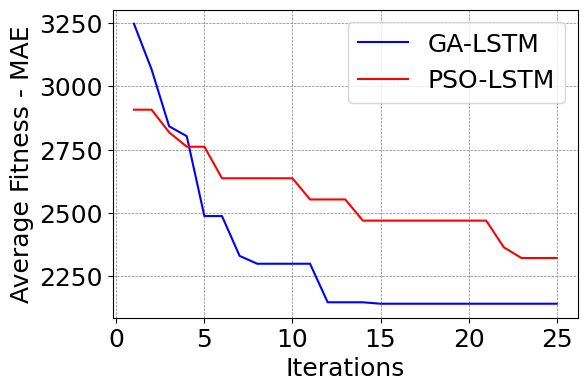

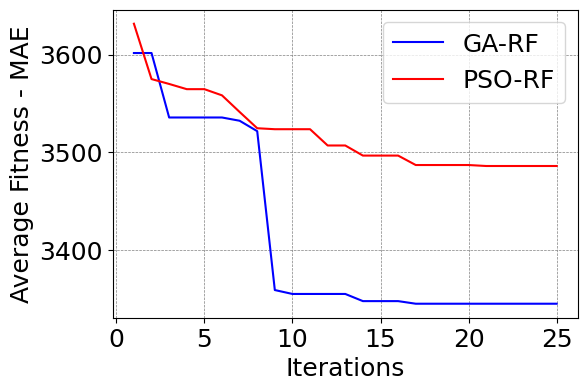

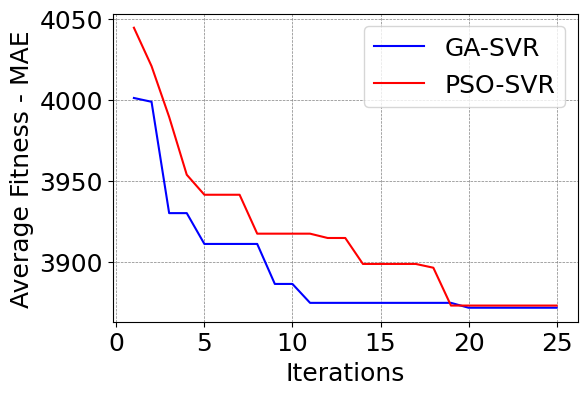

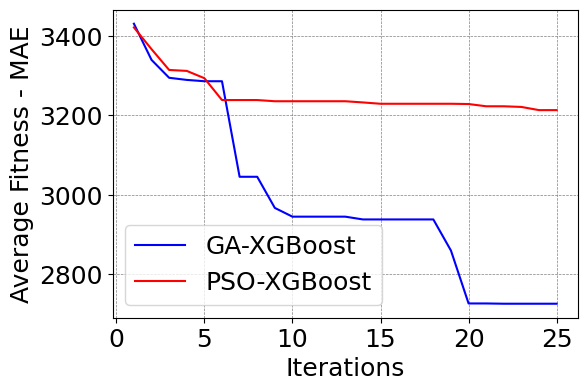

In [5]:

for model in ["ESN", "LSTM", "RF", "SVR"]:
    plt.figure(figsize=(6, 4))
    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] = 18
    plt.rcParams.update({'font.size': 18})
    plt.rcParams['axes.prop_cycle'] = plt.cycler(
        color=["blue", "red"])
    for optimizer in ["GA", "PSO"]:
        try:
            df = pandas.DataFrame()
            for seed, name in [("1000", "A"), ("2000", "B"), ("3000", "C")]:
                new_df = pandas.read_csv(f'parâmetros/{optimizer}-{model} ITERS SEED {seed}.csv', sep=";", decimal=",",
                                         header=0)
                df[seed] = new_df["Fitness"]
            plt.plot(range(1, len(df) + 1), [x for x in df.mean(axis=1)],
                     label=f"{optimizer}-{'XGBoost' if model == 'XGB' else model}")
        except Exception as e:
            continue

    plt.xlabel('Iterations')
    plt.ylabel('Average Fitness - MAE')

    ax = plt.gca()
    ax.set_facecolor('white')
    plt.grid(True, color='grey', linestyle="--", linewidth=0.5)
    plt.legend(facecolor='white')
    plt.savefig(f"Optimization Results/{model}.png", bbox_inches='tight')
    plt.show()


## Best Params

In [6]:
best = {}
for model in ["ESN", "LSTM", "RF", "SVR", "XGB"]:
    df = pandas.DataFrame()
    for optimizer in ["GA", "PSO"]:
        for seed in ["1000", "2000", "3000"]:
            try:
                new_df = pandas.read_csv(f'parâmetros/{optimizer}-{model} ITERS SEED {seed}.csv', sep=";", decimal=",",
                                         header=0)
                df = pandas.concat([df, new_df], axis=0)
            except Exception as e:
                continue

    df = df.sort_values(by=["Fitness"])
    df[df.isnull()] = None
    best[f"{model}"] = df[:1]



### ESN

In [8]:
best["ESN"].transpose()

,10
#,10.000000
Reservoirs,386.000000
Sparsity,0.304537
Spectral Radius,0.539990
Noise,0.059340
Fitness,1404.000000
Base Seed,1000.000000


### LSTM

In [9]:
best["LSTM"].transpose()

,19
Unnamed: 0,19
#,19
Units,115
Epochs,98
Batch Size,117
Activation,None
Bias,True
Fitness,2068
Particle Time start,1721644645.994498
Particle Time end,1721644656.301186


### RF

In [10]:
best["RF"].transpose()

,16
#,1.600000e+01
N_estimators,1.300000e+01
Max_depth,2.810000e+02
Min_samples_split,1.300000e+01
Min_samples_leaf,2.000000e+00
Fitness,3.034000e+03
Particle Time start,1.722099e+09
Particle Time end,1.722099e+09
Particle Time Elapsed,8.420257e+01
Base Seed,2.000000e+03


### SVR

In [11]:
best["SVR"].transpose()

,13
#,13
C,1465.0
Epsilon,1.0
Kernel,sigmoid
Fitness,3864
Particle Time start,1722114729.212679
Particle Time end,1722114761.133929
Particle Time Elapsed,31.921251
Base Seed,1000


### XGB